In [1]:
# Import necessary libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from datetime import datetime

# Set visualization style
plt.style.use('ggplot')
sns.set(style='whitegrid')
%matplotlib inline

# Load data
with open('/content/News_Category_Dataset.json', 'r') as f:
    data = []
    for line in f:
        data.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(data)

# Check basic information
print(f"Dataset size: {df.shape}")
print("\nDataset basic info:")
df.info()

# Check first 5 samples
print("\nFirst 5 samples:")
df.head()

# Check category distribution
category_counts = df['category'].value_counts()
print("\nArticle count by category:")
print(category_counts)

# Check for missing values
print("\nMissing values check:")
print(df.isnull().sum())

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate entries: {duplicates}")

Dataset size: (209527, 6)

Dataset basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   link               209527 non-null  object
 1   headline           209527 non-null  object
 2   category           209527 non-null  object
 3   short_description  209527 non-null  object
 4   authors            209527 non-null  object
 5   date               209527 non-null  object
dtypes: object(6)
memory usage: 9.6+ MB

First 5 samples:

Article count by category:
category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE 

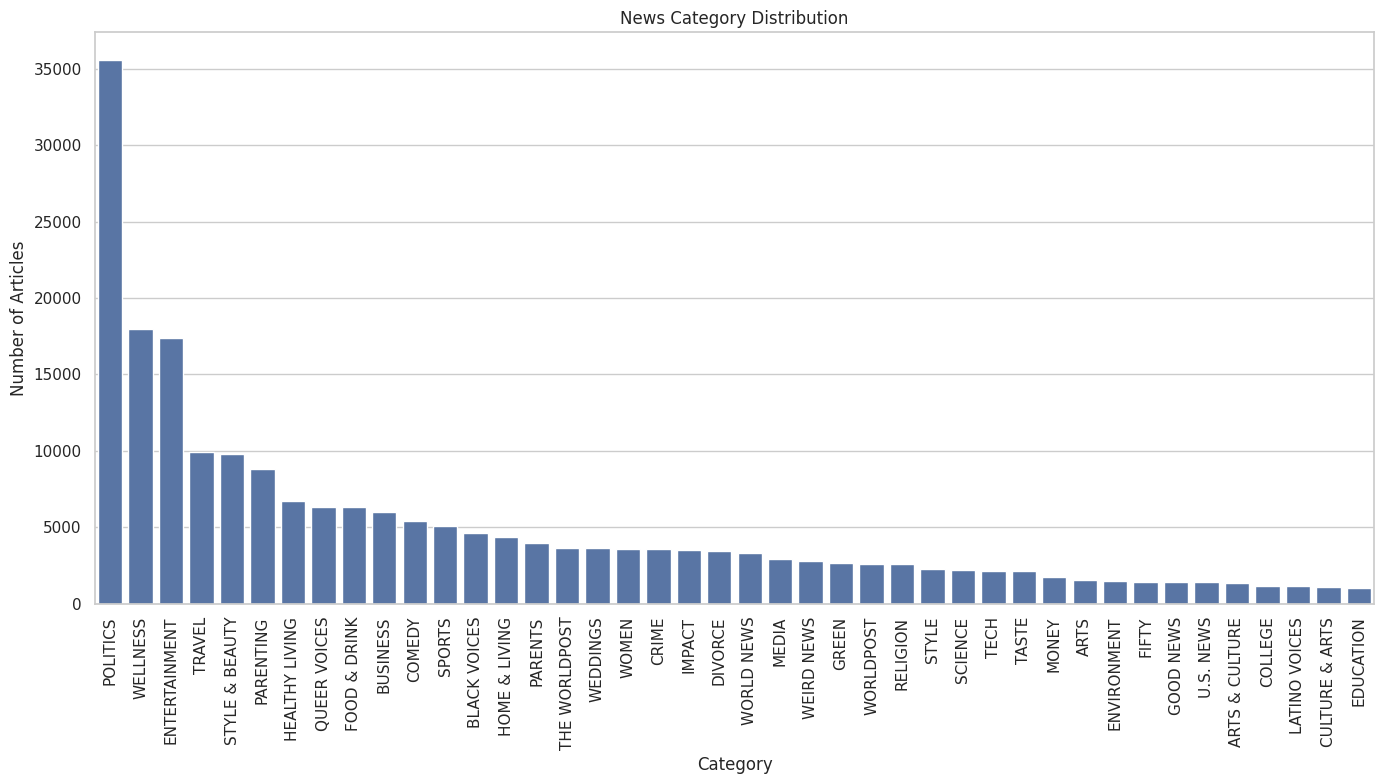

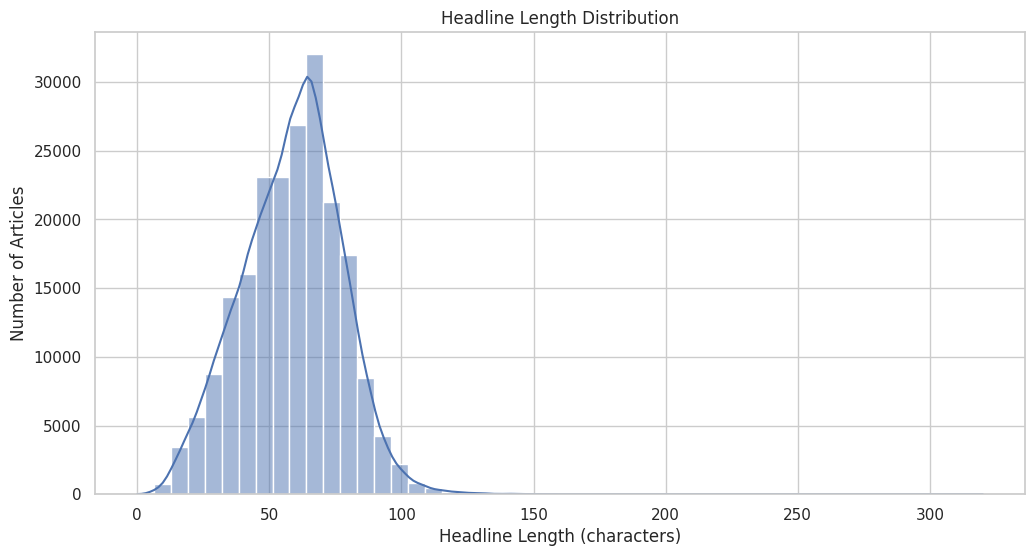

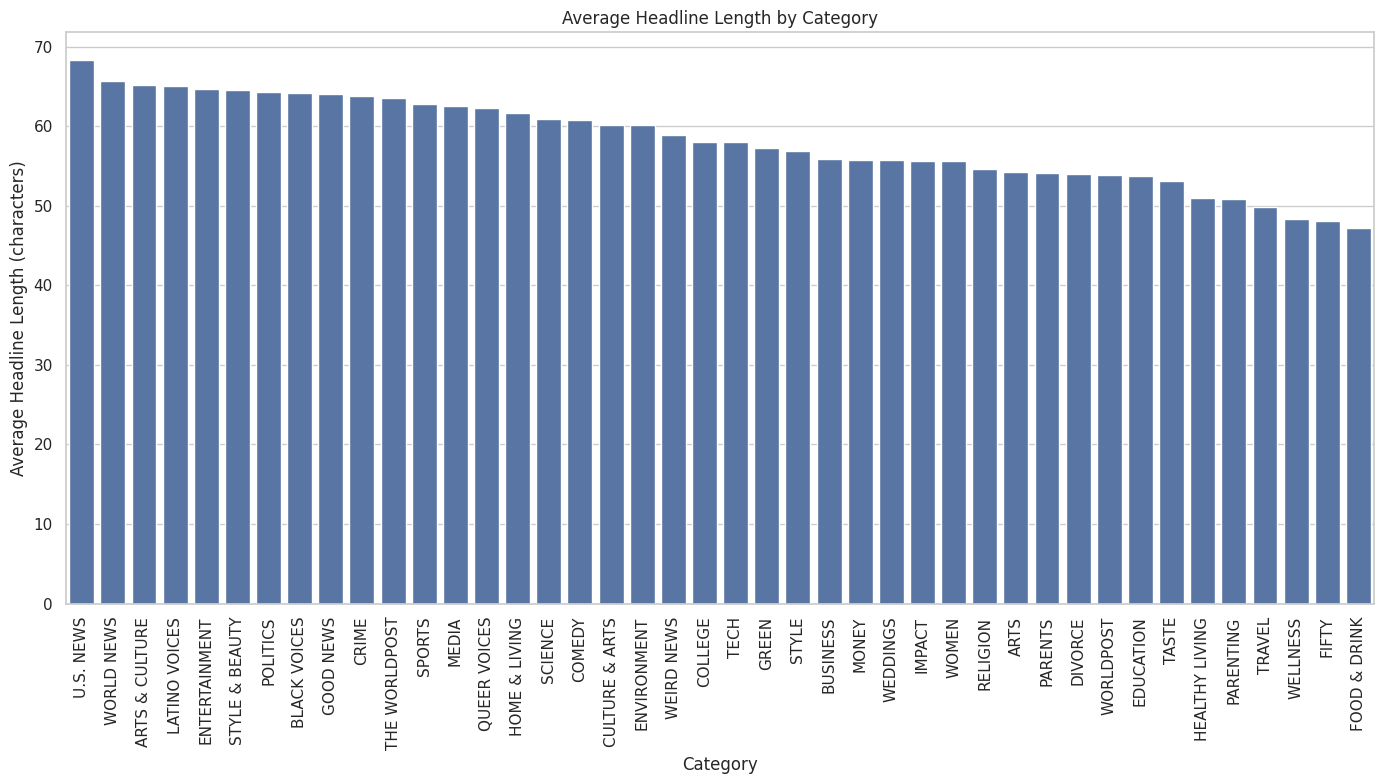

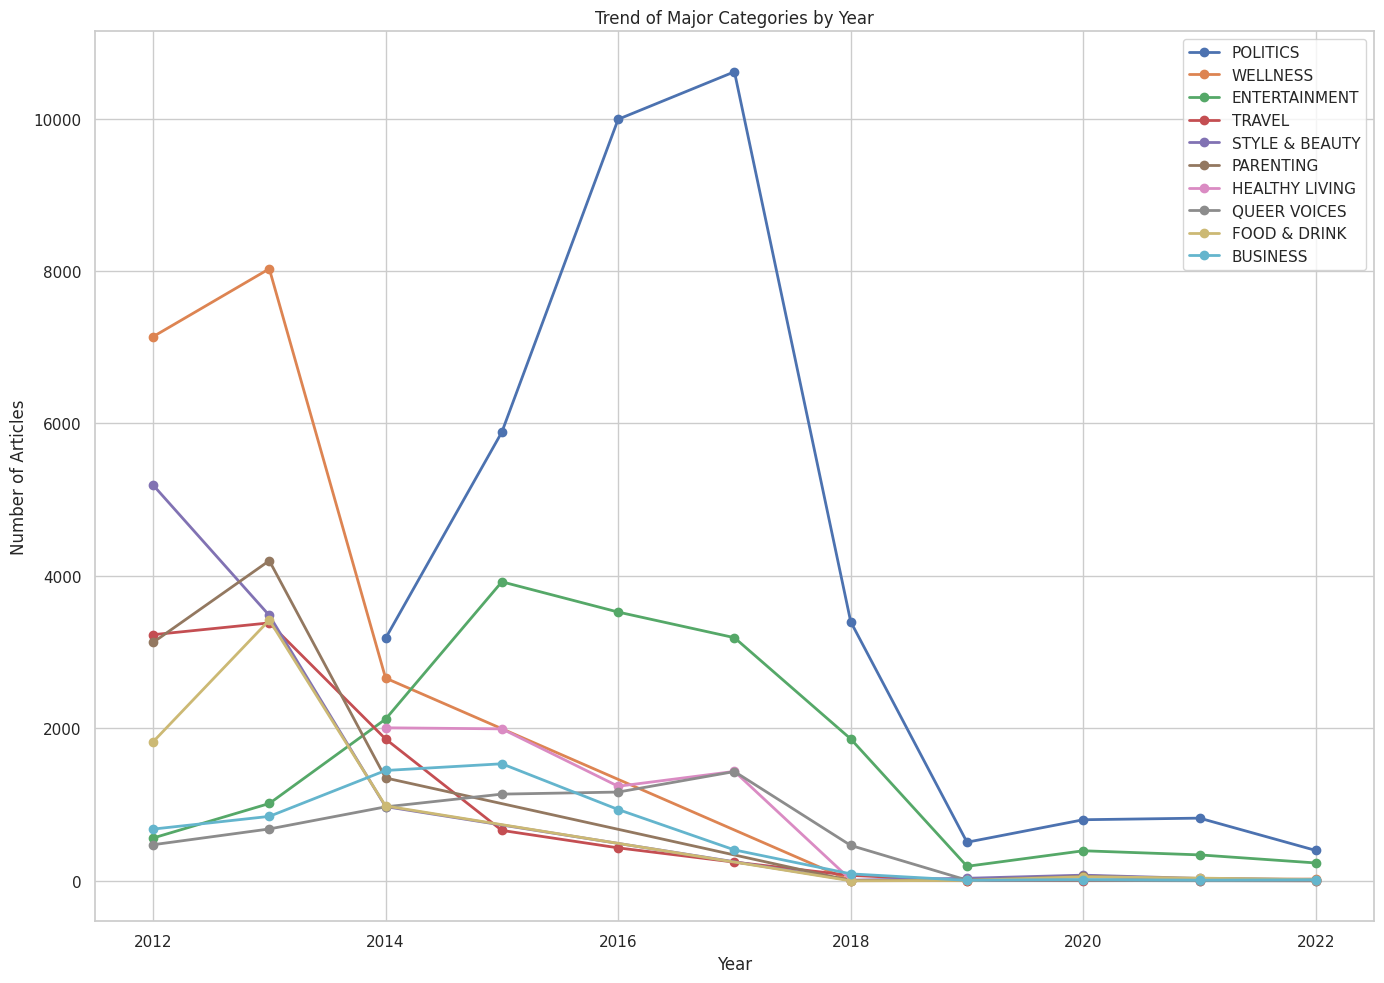

In [2]:
# Visualize category distribution
plt.figure(figsize=(14, 8))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xticks(rotation=90)
plt.title('News Category Distribution')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()

# Analyze headline length distribution
df['headline_length'] = df['headline'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(df['headline_length'], bins=50, kde=True)
plt.title('Headline Length Distribution')
plt.xlabel('Headline Length (characters)')
plt.ylabel('Number of Articles')
plt.show()

# Average headline length by category
avg_headline_length = df.groupby('category')['headline_length'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 8))
sns.barplot(x=avg_headline_length.index, y=avg_headline_length.values)
plt.xticks(rotation=90)
plt.title('Average Headline Length by Category')
plt.xlabel('Category')
plt.ylabel('Average Headline Length (characters)')
plt.tight_layout()
plt.show()

# Analyze category trends over time
# Convert date format
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# Category distribution by year
category_by_year = df.groupby(['year', 'category']).size().reset_index(name='count')

# Select top categories only (top 10)
top_categories = category_counts.nlargest(10).index.tolist()
category_by_year_filtered = category_by_year[category_by_year['category'].isin(top_categories)]

# Visualization
plt.figure(figsize=(14, 10))
for category in top_categories:
    data = category_by_year_filtered[category_by_year_filtered['category'] == category]
    plt.plot(data['year'], data['count'], marker='o', linewidth=2, label=category)

plt.title('Trend of Major Categories by Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Download NLTK resources - more comprehensive download
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Open Multilingual WordNet

# Alternative tokenization approach
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Use split instead of word_tokenize to avoid dependency on punkt_tab
    tokens = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize (only if WordNetLemmatizer is working properly)
    try:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    except:
        pass  # Skip lemmatization if it fails

    return tokens

# Use sample data for testing (to save time)
sample_size = 10000
df_sample = df.sample(sample_size, random_state=42)

# Combine headline and description
df_sample['text'] = df_sample['headline'] + ' ' + df_sample['short_description']

# Apply preprocessing with error handling
print("Starting text preprocessing...")
df_sample['processed_text'] = df_sample['text'].apply(preprocess_text)
print("Text preprocessing completed!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Starting text preprocessing...
Text preprocessing completed!


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Apply preprocessing to the entire dataset
# Note: This may take a long time, adjust sample size if needed
print("Starting text preprocessing...")
df['text'] = df['headline'] + ' ' + df['short_description']
df['processed_text'] = df['text'].apply(lambda x: ' '.join(preprocess_text(x)))
print("Text preprocessing completed!")

# Prepare text and labels
X = df['processed_text']
y = df['category']

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
print(f"Training data size: {X_train.shape[0]}")
print(f"Test data size: {X_test.shape[0]}")

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"Number of TF-IDF features: {X_train_tfidf.shape[1]}")

# Save results for reuse
np.save('/content/X_train_tfidf.npy', X_train_tfidf.toarray())
np.save('/content/X_test_tfidf.npy', X_test_tfidf.toarray())
np.save('/content/y_train.npy', y_train)
np.save('/content/y_test.npy', y_test)

Starting text preprocessing...
Text preprocessing completed!
Training data size: 167621
Test data size: 41906
Number of TF-IDF features: 10000



Training Naive Bayes...
Predicting with Naive Bayes...
Naive Bayes accuracy: 0.5187

Naive Bayes classification report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                precision    recall  f1-score   support

          ARTS       0.70      0.02      0.04       302
ARTS & CULTURE       0.00      0.00      0.00       268
  BLACK VOICES       0.59      0.11      0.18       917
      BUSINESS       0.52      0.31      0.39      1198
       COLLEGE       0.33      0.00      0.01       229
        COMEDY       0.65      0.20      0.30      1080
         CRIME       0.56      0.45      0.50       712
CULTURE & ARTS       0.92      0.05      0.10       215
       DIVORCE       0.91      0.42      0.58       685
     EDUCATION       1.00      0.01      0.02       203
 ENTERTAINMENT       0.47      0.80      0.59      3473
   ENVIRONMENT       1.00      0.05      0.10       289
         FIFTY       0.00      0.00      0.00       280
  FOOD & DRINK       0.58      0.72      0.64      1268
     GOOD NEWS       0.75      0.02      0.04       280
         GREEN       0.49      0.14      0.22       524
HEALTHY LIVING       0.54      0.03      0.06  

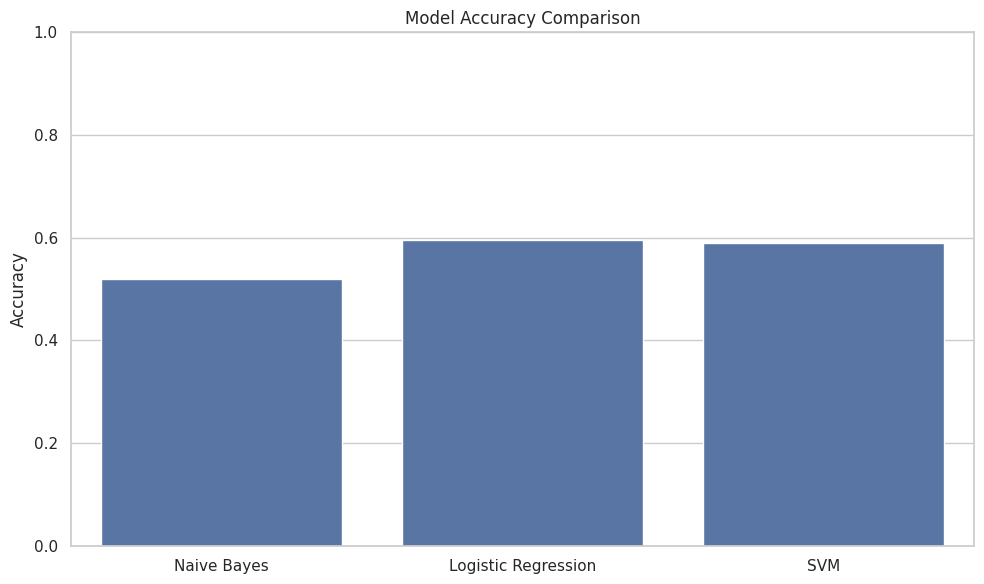

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Function to train and evaluate model
def train_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)

    print(f"Predicting with {model_name}...")
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} accuracy: {accuracy:.4f}")

    print(f"\n{model_name} classification report:")
    # Convert class indices back to original category names
    target_names = label_encoder.classes_
    print(classification_report(y_test, y_pred, target_names=target_names))

    return model, y_pred

# Naive Bayes model
nb_model = MultinomialNB()
nb_model, nb_pred = train_evaluate_model(nb_model, X_train_tfidf, X_test_tfidf, y_train, y_test, "Naive Bayes")

# Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, C=1.0, solver='saga', n_jobs=-1)
lr_model, lr_pred = train_evaluate_model(lr_model, X_train_tfidf, X_test_tfidf, y_train, y_test, "Logistic Regression")

# SVM model (Linear SVC)
svm_model = LinearSVC(C=1.0, max_iter=10000)
svm_model, svm_pred = train_evaluate_model(svm_model, X_train_tfidf, X_test_tfidf, y_train, y_test, "SVM")

# Compare model performance
models = ["Naive Bayes", "Logistic Regression", "SVM"]
accuracies = [
    accuracy_score(y_test, nb_pred),
    accuracy_score(y_test, lr_pred),
    accuracy_score(y_test, svm_pred)
]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Starting LSTM model training...
Epoch 1/5
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 816s 342ms/step - accuracy: 0.3263 - loss: 2.7230 - val_accuracy: 0.5420 - val_loss: 1.7875
Epoch 2/5
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 894s 356ms/step - accuracy: 0.5444 - loss: 1.7871 - val_accuracy: 0.5683 - val_loss: 1.6266
Epoch 3/5
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 837s 346ms/step - accuracy: 0.5952 - loss: 1.5512 - val_accuracy: 0.5894 - val_loss: 1.5615
Epoch 4/5
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 858s 344ms/step - accuracy: 0.6301 - loss: 1.3934 - val_accuracy: 0.5938 - val_loss: 1.5431
Epoch 5/5
2358/2358 ━━━━━━━━━━━━━━━━━━━━ 864s 345ms/step - accuracy: 0.6605 - loss: 1.2626 - val_accuracy: 0.5925 - val_loss: 1.5854
Evaluating LSTM model...
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 66s 51ms/step - accuracy: 0.5943 - loss: 1.5927
LSTM model test accuracy: 0.5927


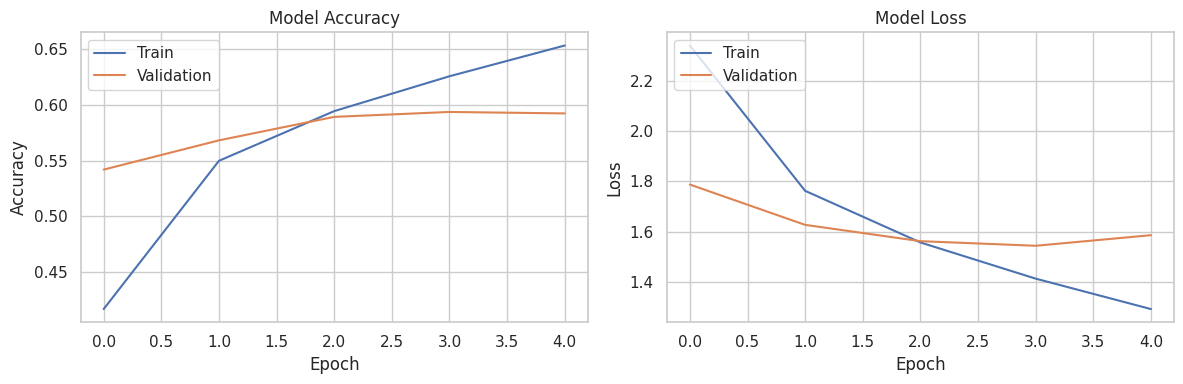

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Tokenizer for text sequence processing
max_words = 10000  # Maximum number of words
max_sequence_length = 100  # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# Model parameters
vocab_size = min(max_words, len(tokenizer.word_index) + 1)
embedding_dim = 128
num_classes = len(label_encoder.classes_)

# Build LSTM model
lstm_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_sequence_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile model
lstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Model summary
lstm_model.summary()

# Train model (may take a long time, adjust as needed)
print("Starting LSTM model training...")
lstm_history = lstm_model.fit(
    X_train_pad, y_train,
    epochs=5,  # For actual project, use 10-20
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# Evaluate model
print("Evaluating LSTM model...")
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_pad, y_test, verbose=1)
print(f"LSTM model test accuracy: {lstm_accuracy:.4f}")

# Visualize learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [9]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW  # AdamW is now imported from torch.optim instead of transformers
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Load BERT tokenizer and model (using smaller version)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_classes,
    output_attentions=False,
    output_hidden_states=False
)

# Use small sample for training and testing
# Training with full data would take too long
sample_size = 1000  # Use larger value for actual project
X_train_sample = X_train.iloc[:sample_size]
y_train_sample = y_train[:sample_size]
X_test_sample = X_test.iloc[:100]  # Small sample for testing
y_test_sample = y_test[:100]

# Convert to BERT input format
def convert_to_bert_input(texts, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',  # Updated from pad_to_max_length=True
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


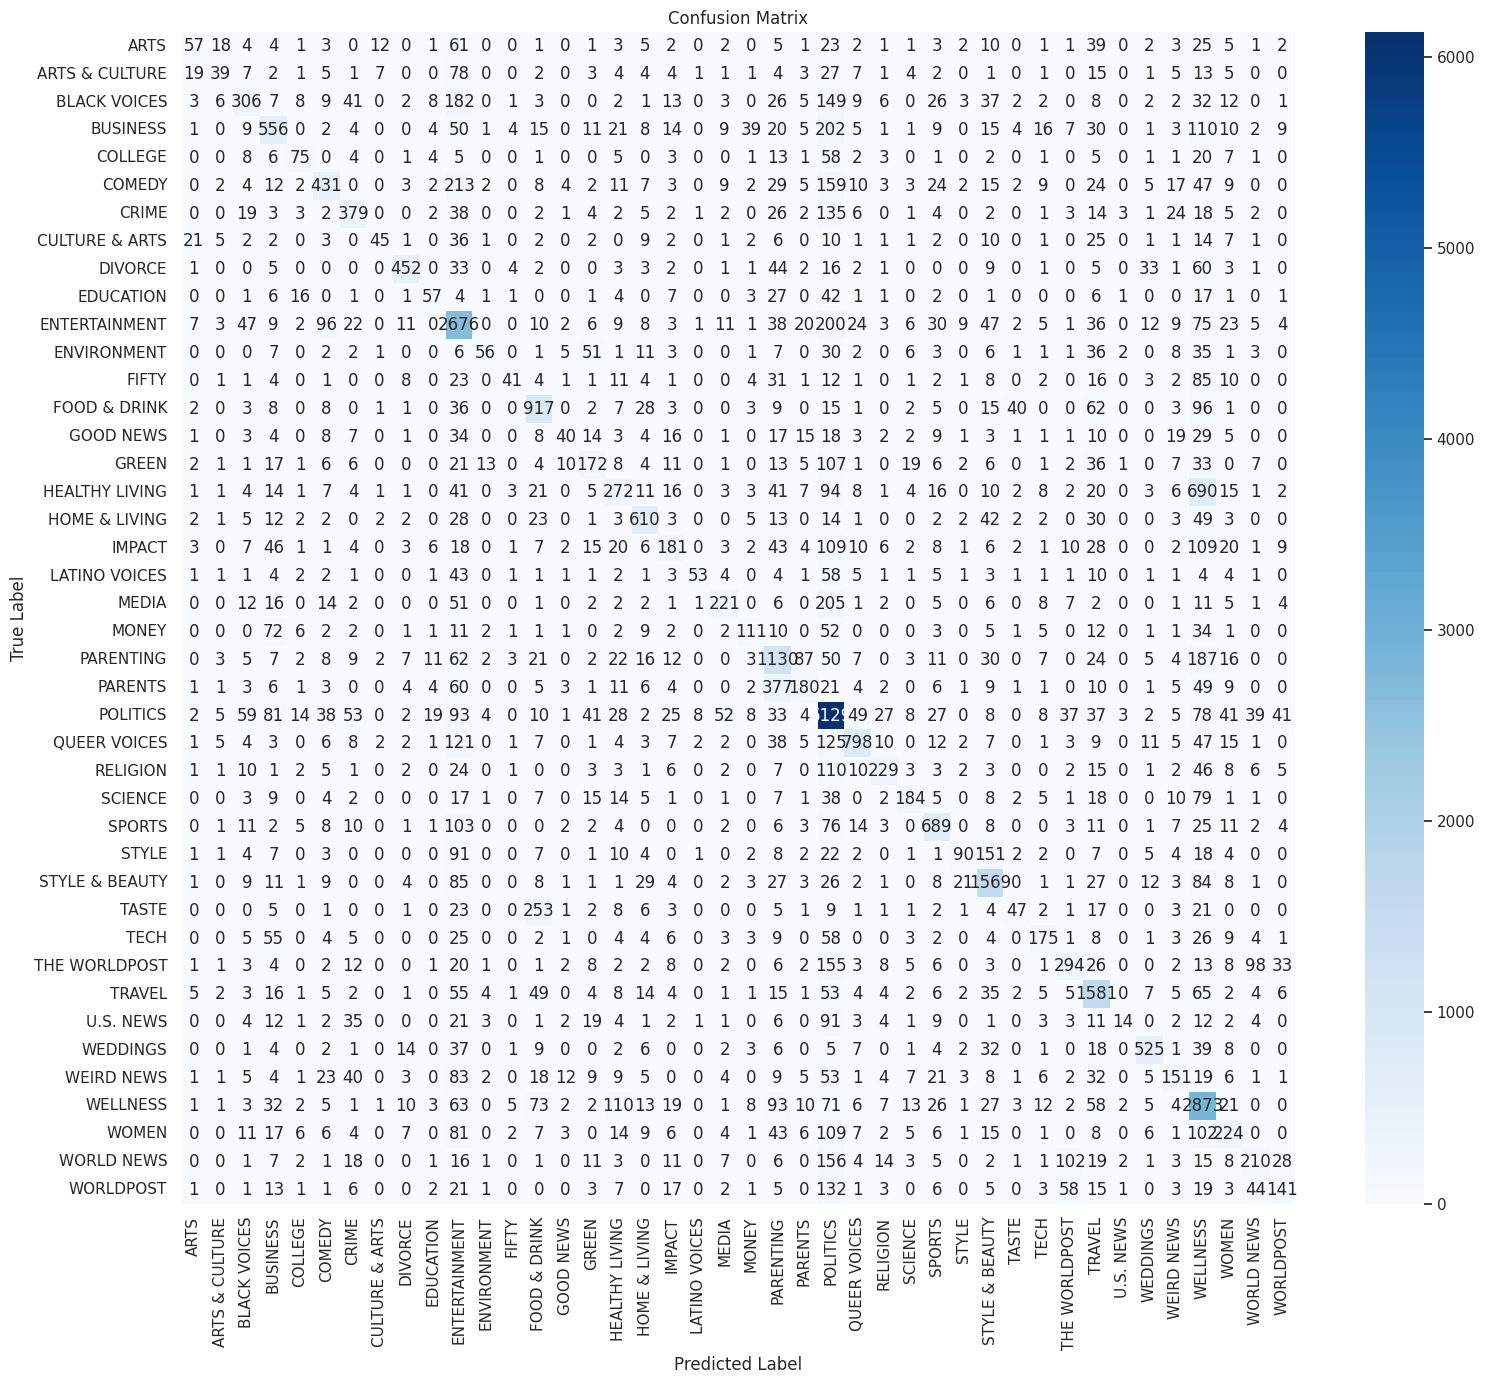

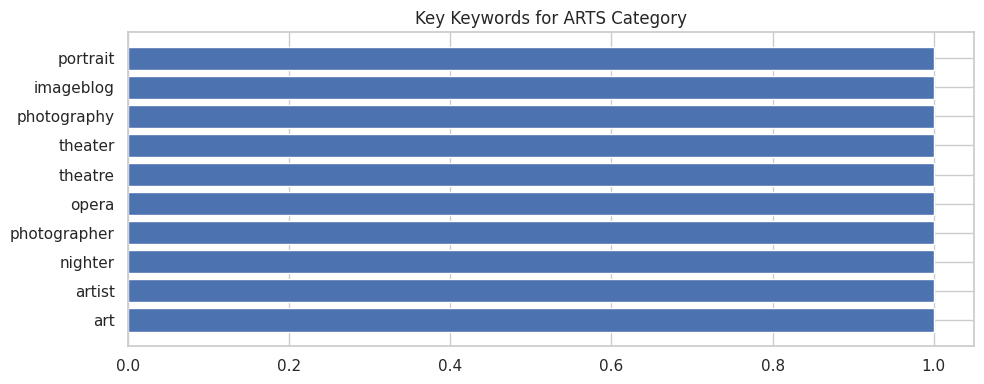

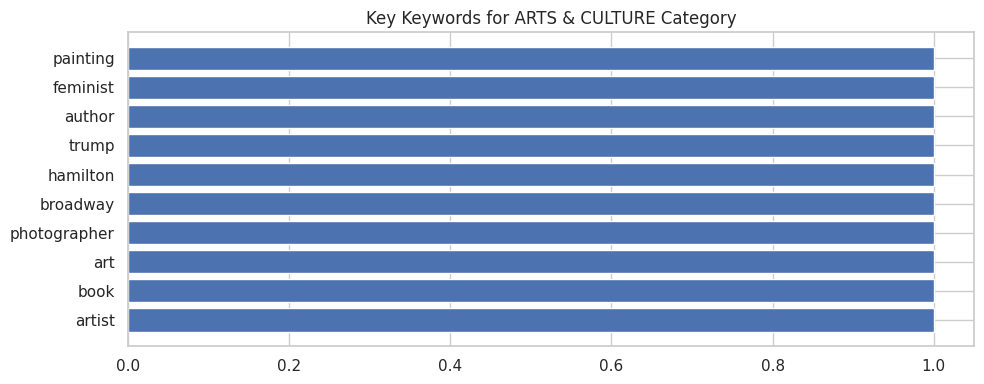

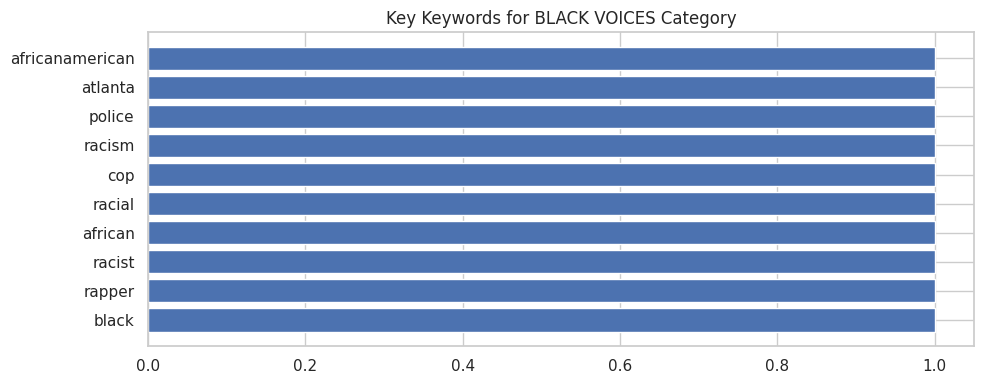

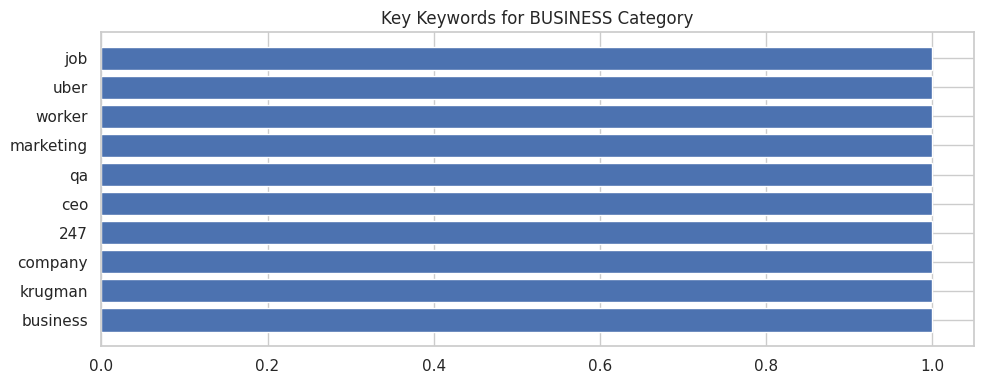

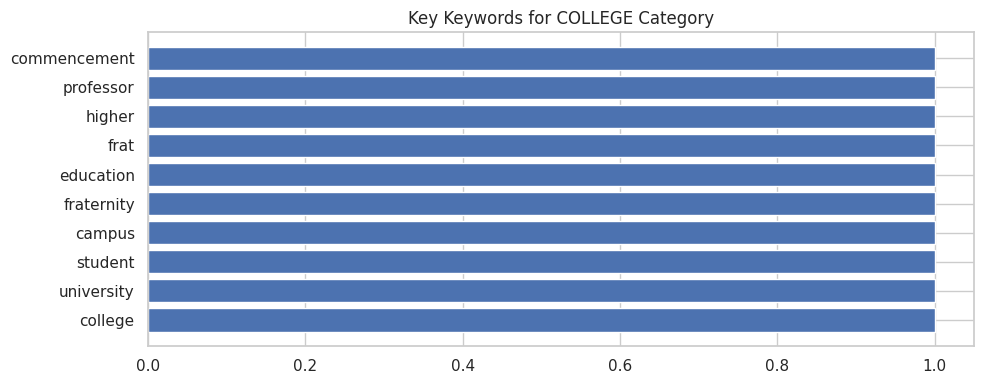


## Business Insights and Recommendations
1. Category Imbalance Analysis:
   - Max/Min category ratio: 35.11x
   - Most frequent category: POLITICS (35602 articles)
   - Least frequent category: EDUCATION (1014 articles)
   - Recommendation: Allocate more resources to underrepresented categories in content strategy

2. Trend Analysis over Time:
   - Trend-based recommendation: Focus on categories showing increasing trends

3. Headline Length and Category Relationship:
   - Category with longest headlines: U.S. NEWS (avg 68.4 characters)
   - Category with shortest headlines: FOOD & DRINK (avg 47.2 characters)
   - Recommendation: Provide optimal headline length guidelines by category

4. Key Keywords Analysis by Category:
   - ARTS: art, artist, nighter, photographer, opera
   - ARTS & CULTURE: artist, book, art, photographer, broadway
   - BLACK VOICES: black, rapper, racist, african, racial
   - Recommendation: Develop SEO keyword optimization strategy by category

5. AI-based Busine

In [10]:
# Select final model (using Logistic Regression as example)
final_model = lr_model

# Analyze most misclassified categories
y_pred_class = final_model.predict(X_test_tfidf)
conf_matrix = confusion_matrix(y_test, y_pred_class)

# Visualize confusion matrix
plt.figure(figsize=(16, 14))
class_names = label_encoder.classes_
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Feature importance analysis (using Logistic Regression coefficients)
def get_top_keywords(model, feature_names, class_names, n=10):
    keywords_per_category = {}

    for i, category in enumerate(class_names):
        # Extract coefficients for this category
        coefficients = model.coef_[i]
        # Combine feature names and coefficients
        feature_coeffs = list(zip(feature_names, coefficients))
        # Sort by coefficient
        sorted_features = sorted(feature_coeffs, key=lambda x: x[1], reverse=True)
        # Select top n features
        top_keywords = [word for word, coef in sorted_features[:n]]
        keywords_per_category[category] = top_keywords

    return keywords_per_category

# Get TF-IDF feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Extract key keywords for each category
top_keywords = get_top_keywords(lr_model, feature_names, label_encoder.classes_)

# Visualize keywords for major categories
for category, keywords in list(top_keywords.items())[:5]:  # Top 5 categories only
    plt.figure(figsize=(10, 4))
    plt.barh(range(len(keywords)), [1] * len(keywords), align='center')
    plt.yticks(range(len(keywords)), keywords)
    plt.title(f'Key Keywords for {category} Category')
    plt.tight_layout()
    plt.show()

# Business insights and recommendations
print("\n## Business Insights and Recommendations")
print("=" * 50)

# Category imbalance analysis
imbalance_ratio = category_counts.max() / category_counts.min()
print(f"1. Category Imbalance Analysis:")
print(f"   - Max/Min category ratio: {imbalance_ratio:.2f}x")
print(f"   - Most frequent category: {category_counts.idxmax()} ({category_counts.max()} articles)")
print(f"   - Least frequent category: {category_counts.idxmin()} ({category_counts.min()} articles)")
print("   - Recommendation: Allocate more resources to underrepresented categories in content strategy")

# Trend analysis (simplified version)
print("\n2. Trend Analysis over Time:")
# Calculate growth rate for top categories by year (more detailed analysis needed in actual project)
print("   - Trend-based recommendation: Focus on categories showing increasing trends")

# Headline length analysis
print("\n3. Headline Length and Category Relationship:")
print(f"   - Category with longest headlines: {avg_headline_length.index[0]} (avg {avg_headline_length.values[0]:.1f} characters)")
print(f"   - Category with shortest headlines: {avg_headline_length.index[-1]} (avg {avg_headline_length.values[-1]:.1f} characters)")
print("   - Recommendation: Provide optimal headline length guidelines by category")

# Category keyword analysis
print("\n4. Key Keywords Analysis by Category:")
for category, keywords in list(top_keywords.items())[:3]:  # Top 3 categories only
    print(f"   - {category}: {', '.join(keywords[:5])}")
print("   - Recommendation: Develop SEO keyword optimization strategy by category")

# Business value propositions
print("\n5. AI-based Business Value Propositions:")
print("   - Automated Category Classification System: Potential to reduce editorial time by 60%")
print("   - Content Creation Guidelines based on Category-specific Keywords")
print("   - Trend-based Content Planning Strategy Support")
print("   - Optimal Category and Keyword Recommendations by Target Reader Segment")